In [6]:
import torch
# !pip install torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn.norm import BatchNorm

In [7]:
dataset = ZINC(root = '', split='train')

In [110]:
batch_size = 128

In [111]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [112]:
loader

In [113]:
from torch_geometric.nn import GATConv, TopKPooling
# from torch_geometric.nn import DiffPool
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_max_pool as gmp

In [114]:
num_embeddings = len(dataset.data.x.unique())

/opt/conda/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:157: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [115]:
class GAT_model(torch.nn.Module):
    def __init__(self, embedding_size=32):
        super().__init__()
        
        self.embedding_size = embedding_size
        
        # embed and transform
        self.embed = torch.nn.Embedding(
            num_embeddings, self.embedding_size)
        
        self.first_transform = torch.nn.Linear(embedding_size, embedding_size)
        self.relu = torch.nn.ReLU()
        
        # first block
        self.conv1 = GATConv(
            self.embedding_size, self.embedding_size, heads=3, dropout=0.2)
        self.head_reshape1 = torch.nn.Linear(
            self.embedding_size*3, self.embedding_size)
        self.pool1 = TopKPooling(embedding_size, ratio=0.6)
        
        # second block
        self.conv2 = GATConv(
            self.embedding_size, self.embedding_size, heads=3, dropout=0.2)
        self.head_reshape2 = torch.nn.Linear(
            self.embedding_size*3, self.embedding_size)
        self.pool2 = TopKPooling(self.embedding_size, ratio=0.5)
        
        # third block
        self.conv3 = GATConv(
            self.embedding_size, self.embedding_size, heads=3, dropout=0.2)
        self.head_reshape3 = torch.nn.Linear(
            self.embedding_size*3, self.embedding_size)
        self.pool3 = TopKPooling(self.embedding_size, ratio=0.3)
        
        # final FF block
        self.linear1 = torch.nn.Linear(6*self.embedding_size, self.embedding_size//2)
        self.linear2 = torch.nn.Linear(self.embedding_size//2, 1)
    
        
    
    def forward(self, x, edge_index, batch_index):
        x = self.embed(x)
        x = x.reshape(-1, self.embedding_size)
        
        x = self.first_transform(x)
        x = self.relu(x)
        
        # block 1
        x = self.conv1(x, edge_index)
        x = self.relu(x)
        x = self.head_reshape1(x)
        x, edge_index, _, batch_index, _, _ = self.pool1(
            x, edge_index, None, batch_index)
        # aggregate intermediate values
        pooled1 = torch.cat([gap(x, batch_index), gmp(x, batch_index)], dim=1)
        
        # block 2
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.head_reshape2(x)
        x, edge_index, _, batch_index, _, _ = self.pool2(
            x, edge_index, None, batch_index)
        # aggregate intermediate values
        pooled2 = torch.cat([gap(x, batch_index), gmp(x, batch_index)], dim=1)
        
        # block 3
        x = self.conv3(x, edge_index)
        x = self.relu(x)
        x = self.head_reshape3(x)
        x, edge_index, _, batch_index, _, _ = self.pool3(
            x, edge_index, None, batch_index)
        
        pooled3 = torch.cat([gap(x, batch_index), gmp(x, batch_index)], dim=1)
        
        # final block 
        x = torch.cat([pooled1, pooled2, pooled3], dim=1)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        
        return x

In [116]:
model = GAT_model(128)

In [117]:
def get_num_params(model):
    return sum(param.numel() for param in model.parameters())

In [118]:
get_num_params(model)

368513

In [119]:
# model(batch.x, batch.edge_index, batch.batch)

In [121]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [122]:
device

device(type='cuda')

In [123]:
num_epochs = 10


running_loss = 0.0
counter = 0

losses = []
for epoch in range(num_epochs):
    for i, batch in enumerate(loader):
        model.train()
        
        model.zero_grad()
        
        batch = batch.to(device)
        
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = loss_fn(out.reshape(-1,), batch.y)
        loss.backward()
        
        loss_val = loss.item()
        running_loss += loss_val
        counter += 1
        if i % 50 == 50 - 1 or i == (len(loader))-1:
            mean_loss_val = running_loss / counter
            print(f'[{epoch}/{num_epochs-1}][{i}/{len(loader)}]|\t Loss:{mean_loss_val}')
            losses.append(mean_loss_val)
            counter = 0
            running_loss = 0
        optimizer.step()
        

/opt/conda/lib/python3.10/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "


[0/9][49/1719]|	 Loss:3.8294248485565188
[0/9][99/1719]|	 Loss:3.956041164398193
[0/9][149/1719]|	 Loss:4.085049519538879
[0/9][199/1719]|	 Loss:4.556201400756836
[0/9][249/1719]|	 Loss:3.8545457029342653
[0/9][299/1719]|	 Loss:3.4375034093856813
[0/9][349/1719]|	 Loss:2.6742877054214476
[0/9][399/1719]|	 Loss:2.225312066078186
[0/9][449/1719]|	 Loss:2.2545053791999816
[0/9][499/1719]|	 Loss:2.865952470302582
[0/9][549/1719]|	 Loss:2.4998528504371644
[0/9][599/1719]|	 Loss:2.0103600025177
[0/9][649/1719]|	 Loss:2.0707711672782896
[0/9][699/1719]|	 Loss:2.1930810952186586
[0/9][749/1719]|	 Loss:2.190649765729904
[0/9][799/1719]|	 Loss:1.9713774299621583
[0/9][849/1719]|	 Loss:2.0299266815185546
[0/9][899/1719]|	 Loss:2.01012757897377
[0/9][949/1719]|	 Loss:1.950772979259491
[0/9][999/1719]|	 Loss:2.154276406764984
[0/9][1049/1719]|	 Loss:1.9495394015312195
[0/9][1099/1719]|	 Loss:2.317816890478134
[0/9][1149/1719]|	 Loss:2.0577524197101593
[0/9][1199/1719]|	 Loss:2.0567269206047056
[0/9

In [124]:
import matplotlib.pyplot as plt
from matplotlib import collections  as mc


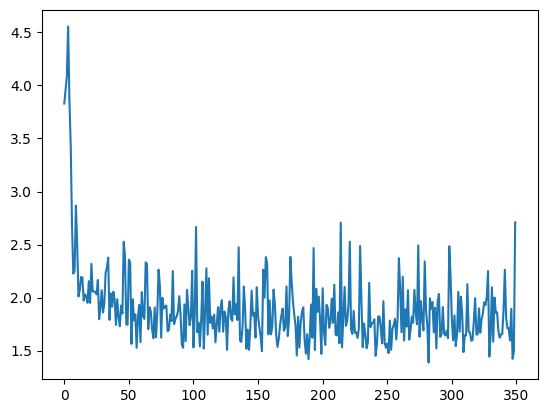

In [125]:
plt.plot(losses)

In [126]:
# with torch.no_grad():
#     out = model(data.x, data)

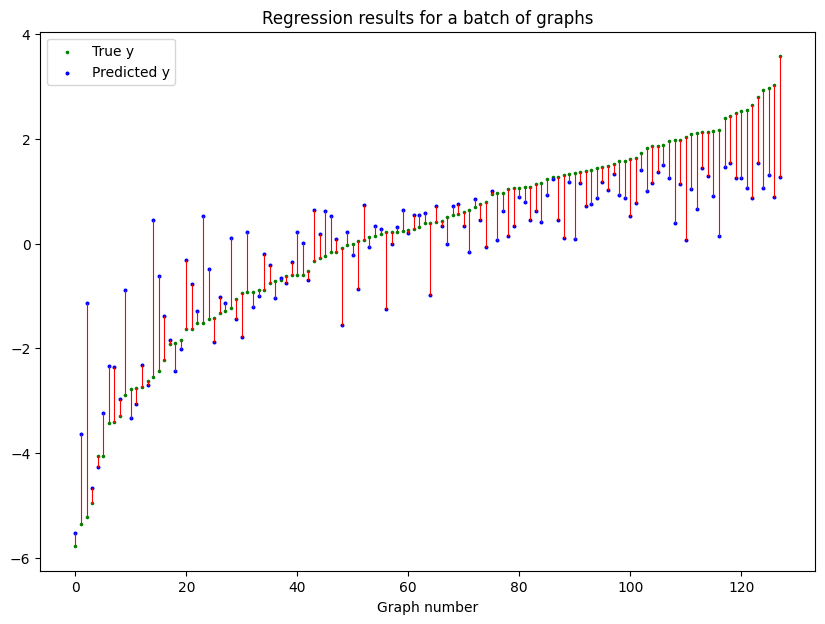

In [162]:
_, batch = next(enumerate(loader))
batch = batch.to(device)

with torch.no_grad():
    model.eval()
    out = model(batch.x, batch.edge_index, batch.batch)
    
    
sorted_y, sorted_indices = torch.sort(batch.y)
fig, ax = plt.subplots(figsize=(10, 7))

y1 = sorted_y.cpu()
y2 = out.reshape(-1,)[sorted_indices].cpu()

# create lines between true and predicted value
lines = []
i=0
for true, pred in zip(y1, y2):
    lines.append([(i,true),(i,pred)])
    i += 1
    
lc = mc.LineCollection(lines, linewidths=0.8, color='red')

ax.scatter([i for i in range(len(batch.y))], y1, s=2.5, label='True y', color='green')
ax.scatter([i for i in range(len(batch.y))], y2, s=3.5, label='Predicted y', color='blue')
ax.add_collection(lc)

ax.set_xlabel('Graph number')

ax.set_title('Regression results for a batch of graphs')
ax.legend()
fig.show()

In [163]:
diff_sum = 0.0
cc = 0
for line in lines:
    diff_sum += (line[0][1] - line[1][1])**2
    cc += 1
    
print(diff_sum / cc)

tensor(0.9852)


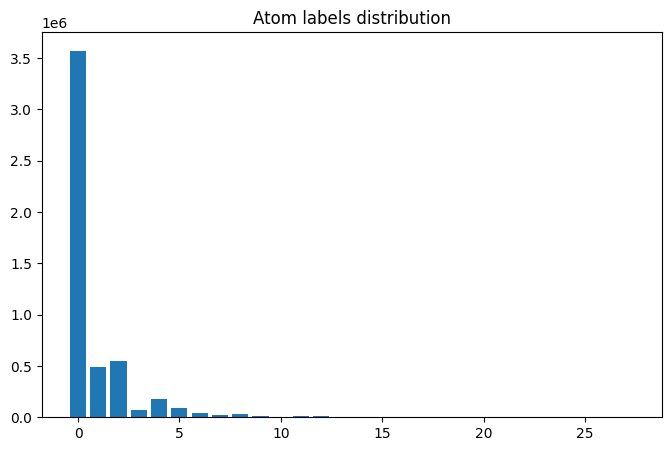

In [164]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(torch.unique(dataset.data.x, return_counts=True)[0], torch.unique(dataset.data.x, return_counts=True)[1])
ax.set_title('Atom labels distribution')
fig.show()

In [165]:
ids = torch.tensor([i for i in range(num_embeddings)]).to(device)